In [83]:
#import packages
import pandas as pd
from skopt import BayesSearchCV
import matplotlib.pyplot as plt

In [68]:
#read files
humidity = pd.read_csv('humidity.csv')
temperature = pd.read_csv('temperature.csv')
pressure = pd.read_csv('pressure.csv')
weather_description = pd.read_csv('weather_description.csv')
wind_direction = pd.read_csv('wind_direction.csv')
wind_speed = pd.read_csv('wind_speed.csv')

In [69]:
weather = pd.merge(humidity, temperature, on='datetime', suffixes=('_humidity', '_temperature'))
weather = pd.merge(weather, weather_description, on='datetime', suffixes= ('', '_weather_desc'))
weather = pd.merge(weather, wind_direction, on='datetime', suffixes=('', '_wind_direction'))
weather = pd.merge(weather, wind_speed, on='datetime', suffixes=('', '_wind_speed'))
weather = pd.merge(weather, pressure, on='datetime', suffixes=('', '_pressure'))
weather.dropna(inplace=True)
print(weather.shape)
weather.head()

(35101, 217)


,datetime,Vancouver_humidity,Portland_humidity,San Francisco_humidity,Seattle_humidity,Los Angeles_humidity,San Diego_humidity,Las Vegas_humidity,Phoenix_humidity,Albuquerque_humidity,...,Philadelphia_pressure,New York_pressure,Montreal_pressure,Boston_pressure,Beersheba_pressure,Tel Aviv District_pressure,Eilat_pressure,Haifa_pressure,Nahariyya_pressure,Jerusalem_pressure
27,2012-10-02 15:00:00,89.0,76.0,51.0,87.0,88.0,73.0,16.0,17.0,41.0,...,1014.0,1012.0,1002.0,1014.0,985.0,1013.0,1011.0,1013.0,1013.0,990.0
45,2012-10-03 09:00:00,81.0,77.0,68.0,71.0,53.0,78.0,19.0,25.0,39.0,...,1015.0,1015.0,1013.0,1013.0,985.0,1014.0,1013.0,1013.0,1013.0,991.0
49,2012-10-03 13:00:00,87.0,81.0,42.0,81.0,64.0,64.0,21.0,28.0,50.0,...,1016.0,1017.0,1015.0,1014.0,985.0,1013.0,1010.0,1013.0,1013.0,990.0
68,2012-10-04 08:00:00,72.0,71.0,55.0,40.0,77.0,83.0,20.0,25.0,25.0,...,1016.0,1016.0,1018.0,1017.0,987.0,1016.0,1014.0,1013.0,1013.0,992.0
72,2012-10-04 12:00:00,43.0,66.0,72.0,56.0,82.0,88.0,28.0,31.0,43.0,...,1017.0,1018.0,1019.0,1020.0,986.0,1013.0,1011.0,1013.0,1013.0,991.0


In [70]:
#look at Indianapolis specifically
indy_weather = weather.filter(regex='Indianapolis|datetime', axis=1)
indy_weather.head()

,datetime,Indianapolis_humidity,Indianapolis_temperature,Indianapolis,Indianapolis_wind_direction,Indianapolis_wind_speed,Indianapolis_pressure
27,2012-10-02 15:00:00,71.0,286.47,overcast clouds,60.0,5.0,1011.0
45,2012-10-03 09:00:00,100.0,285.15,mist,50.0,8.0,1006.0
49,2012-10-03 13:00:00,93.0,285.56,drizzle,30.0,6.0,1007.0
68,2012-10-04 08:00:00,93.0,286.86,overcast clouds,180.0,5.0,1013.0
72,2012-10-04 12:00:00,93.0,286.45,mist,180.0,4.0,1016.0


In [71]:
# Create a copy of the DataFrame to avoid modifying the original data
indy_weather = indy_weather.copy()
# Convert the 'datetime' column to a datetime object
indy_weather.loc[:, 'datetime'] = pd.to_datetime(indy_weather['datetime'], format='%Y-%m-%d %H:%M:%S')

# Extract year, month, day, hour, and day_of_week from the 'datetime' column
indy_weather.loc[:, 'year'] = indy_weather['datetime'].dt.year
indy_weather.loc[:, 'month'] = indy_weather['datetime'].dt.month
indy_weather.loc[:, 'day'] = indy_weather['datetime'].dt.day
indy_weather.head()


,datetime,Indianapolis_humidity,Indianapolis_temperature,Indianapolis,Indianapolis_wind_direction,Indianapolis_wind_speed,Indianapolis_pressure,year,month,day
27,2012-10-02 15:00:00,71.0,286.47,overcast clouds,60.0,5.0,1011.0,2012,10,2
45,2012-10-03 09:00:00,100.0,285.15,mist,50.0,8.0,1006.0,2012,10,3
49,2012-10-03 13:00:00,93.0,285.56,drizzle,30.0,6.0,1007.0,2012,10,3
68,2012-10-04 08:00:00,93.0,286.86,overcast clouds,180.0,5.0,1013.0,2012,10,4
72,2012-10-04 12:00:00,93.0,286.45,mist,180.0,4.0,1016.0,2012,10,4


In [72]:
# Group by 'year', 'month', and 'day' columns and calculate the mean values for each day
daily_data = indy_weather.groupby(['year', 'month', 'day']).mean().reset_index()

# Create a new 'date' column by combining the 'year', 'month', and 'day' columns
daily_data['date'] = pd.to_datetime(daily_data[['year', 'month', 'day']])

# Set the DataFrame index to the new 'date' column
daily_data.set_index('date', inplace=True)
daily_data.head()


,year,month,day,Indianapolis_humidity,Indianapolis_temperature,Indianapolis_wind_direction,Indianapolis_wind_speed,Indianapolis_pressure
date,,,,,,,,
2012-10-02,2012,10,2,71.0,286.470,60.0,5.0,1011.0
2012-10-03,2012,10,3,96.5,285.355,40.0,7.0,1006.5
2012-10-04,2012,10,4,93.0,286.655,180.0,4.5,1014.5
2012-10-06,2012,10,6,77.0,291.280,210.0,3.0,1020.0
2012-10-10,2012,10,10,52.0,287.600,204.0,5.0,996.0


In [73]:
# Map month values to season labels
season_mapping = {
    1: 'Winter',
    2: 'Winter',
    3: 'Spring',
    4: 'Spring',
    5: 'Spring',
    6: 'Summer',
    7: 'Summer',
    8: 'Summer',
    9: 'Autumn',
    10: 'Autumn',
    11: 'Autumn',
    12: 'Winter'
}
daily_data['season'] = daily_data['month'].map(season_mapping)
daily_data_encoded = pd.get_dummies(daily_data, columns=['season'])

daily_data_encoded.head()

,year,month,day,Indianapolis_humidity,Indianapolis_temperature,Indianapolis_wind_direction,Indianapolis_wind_speed,Indianapolis_pressure,season_Autumn,season_Spring,season_Summer,season_Winter
date,,,,,,,,,,,,
2012-10-02,2012,10,2,71.0,286.470,60.0,5.0,1011.0,1,0,0,0
2012-10-03,2012,10,3,96.5,285.355,40.0,7.0,1006.5,1,0,0,0
2012-10-04,2012,10,4,93.0,286.655,180.0,4.5,1014.5,1,0,0,0
2012-10-06,2012,10,6,77.0,291.280,210.0,3.0,1020.0,1,0,0,0
2012-10-10,2012,10,10,52.0,287.600,204.0,5.0,996.0,1,0,0,0


In [74]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Define the preprocessing steps and the model
preprocessing_steps = StandardScaler()
model = RandomForestRegressor()  # Random Forest Regression model

# Create the pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessing_steps),
    ('model', model)
])
# Define the input features and the target variable
features = ['year', 'month', 'day', 'Indianapolis_temperature', 'Indianapolis_wind_direction', 'Indianapolis_humidity', 'Indianapolis_pressure', 'season_Autumn','season_Spring', 'season_Summer', 'season_Winter']
target_var = 'Indianapolis_wind_speed'

# Extract the input features and the target variable from the DataFrame
X = daily_data_encoded[features]
y = daily_data_encoded[target_var]



In [79]:
from sklearn.metrics import r2_score, mean_squared_error
# Define the search space for hyperparameters
hyperparameters = {
    'model__n_estimators': (10, 200),  # Range for the number of estimators
    'model__max_depth': (1, 20),  # Range for the maximum depth
    'model__min_samples_split': (2, 10),  # Range for the minimum samples split
}

# Perform Bayesian optimization using BayesSearchCV
opt = BayesSearchCV(pipeline, hyperparameters, n_iter=12, cv=5)


In [80]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline to the training data
opt.fit(X_train, y_train)
# Predict the target variable for the test data
y_pred = opt.predict(X_test)

# Evaluate the performance of the model on the test data
from sklearn.metrics import r2_score, mean_squared_error
print('R2 score:', r2_score(y_test, y_pred))
print('Mean squared error:', mean_squared_error(y_test, y_pred))



R2 score: 0.3955130135490884
Mean squared error: 1.2830961801034326


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

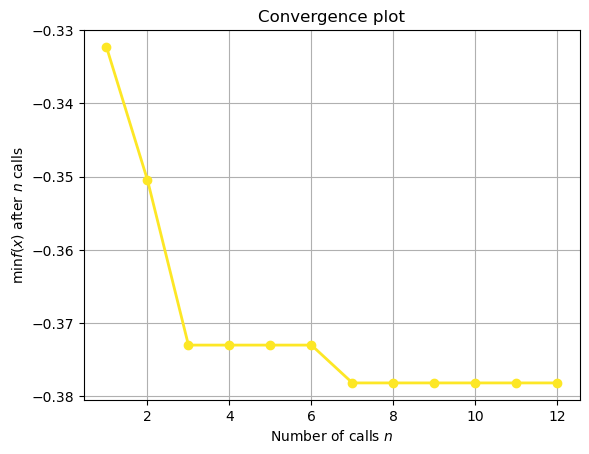

In [81]:
from skopt.plots import plot_convergence

plot_convergence(opt, opt.optimizer_results_[0])

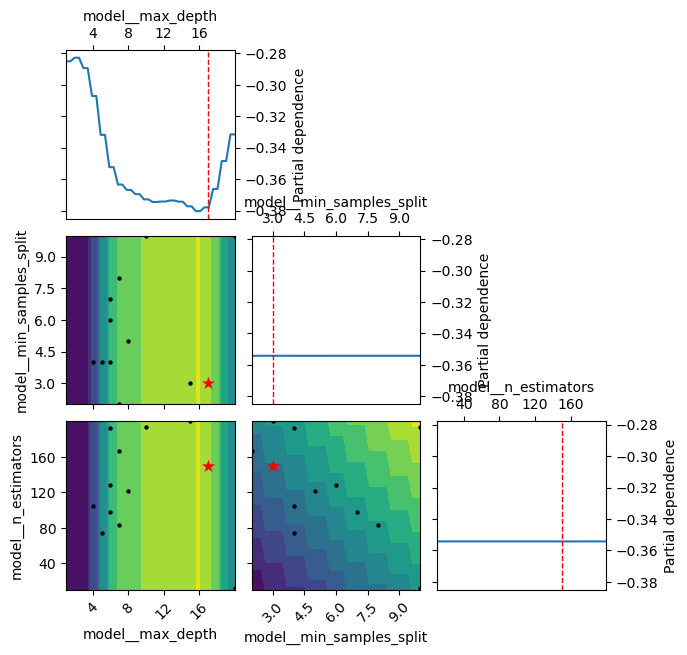

In [84]:
from skopt.plots import plot_objective

_ = plot_objective(opt.optimizer_results_[0])
plt.show()
